In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys

sys.path.append("../../")
import copy
import os
import logging
from src.utils import logging_utils
from src import functional
from src.models import ModelandTokenizer
# from src.data import load_relation
import json
import torch

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

In [34]:
import matplotlib.pyplot as plt
import numpy as np

#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+2)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE - 3)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

def plot_patch_blocking_results(
    patch_recovery,
    attn_severed,
    mlp_severed,
    savepdf=None,
):
    state_indirect_effects = {
        "Recovery": patch_recovery,
        "ATTN Severed": attn_severed,
        "MLP Severed": mlp_severed,
    }
    config_color = {
        "Recovery": "#730099",
        "ATTN Severed": "red",
        "MLP Severed": "green",
    }

    # plt.rcdefaults()
    plt.figure(figsize=(20, 3.9))
    n_layer = len(patch_recovery)

    idx = 0
    bar_width = 0.28
    for config in state_indirect_effects:
        plot_ie = []
        for layer in range(n_layer):
            plot_ie.append(state_indirect_effects[config][layer])
        
        plt.bar(
            np.arange(len(plot_ie)) + idx * bar_width, plot_ie,
            width = bar_width,
            label = config,
            # edgecolor = "black",
            color = config_color[config],
            alpha = 0.8
        )
        idx += 1

    def layer_tick(layer_idx, jump=5):
        return f"{layer_idx}" if layer_idx % jump == 0 else ""

    plt.ylim(-0.1, 1.3)
    plt.yticks(np.arange(0, 1.1, 0.25))
    plt.xticks(
        np.arange(len(patch_recovery)) + bar_width, 
        [layer_tick(i) for i in range(n_layer)]
    )
    
    ylabel = f"Average IE"

    plt.ylabel(ylabel)
    plt.legend(ncol = 4, bbox_to_anchor=(0.5, -.35), loc='lower center', frameon=False)
    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")

    plt.show()


In [35]:
RESULTS_DIR = os.path.join("../../", "results")
MODEL = "pythia-2.8b-deduped"

path_blocking_dir = os.path.join(RESULTS_DIR, "ablation", MODEL)

relations = os.listdir(path_blocking_dir)
relations

['person_occupation',
 'landmark_in_country',
 'company_ceo',
 'country_capital_city',
 'company_hq',
 'place_in_city',
 'person_plays_pro_sport']

In [40]:
at_token = "prompt_last"
# at_token = "subject_last"

patch_recovery_all = []
attn_severed_all = []
mlp_severed_all = []

for relation in relations:
    results_file = os.path.join(path_blocking_dir, relation, f"{at_token}.json")
    try:
        with open(results_file, "r") as f:
            ablation_results = json.load(f)
    except FileNotFoundError:
        print(f"File not found: {results_file} -- skipping...")
        continue
    print(f"{relation}...{len(ablation_results['trials'])} trials.")
    patch_recovery_cur = [trial["patch_recovery"] for trial in ablation_results["trials"]]
    attn_severed_cur = [trial["attn_severed"] for trial in ablation_results["trials"]]
    mlp_severed_cur = [trial["mlp_severed"] for trial in ablation_results["trials"]] 

    patch_recovery_avg = torch.Tensor(patch_recovery_cur).mean(dim=0).squeeze().numpy()
    attn_severed_avg = torch.Tensor(attn_severed_cur).mean(dim=0).squeeze().numpy()
    mlp_severed_avg = torch.Tensor(mlp_severed_cur).mean(dim=0).squeeze().numpy()

    # plot_patch_blocking_results(
    #     patch_recovery_avg,
    #     attn_severed_avg,
    #     mlp_severed_avg,
    # )

    patch_recovery_all += patch_recovery_cur
    attn_severed_all += attn_severed_cur
    mlp_severed_all += mlp_severed_cur

len(patch_recovery_all)

person_occupation...33 trials.
landmark_in_country...150 trials.
File not found: ../../results/ablation/pythia-2.8b-deduped/company_ceo/prompt_last.json -- skipping...
country_capital_city...16 trials.
company_hq...150 trials.
place_in_city...92 trials.
person_plays_pro_sport...139 trials.


580

2024-04-02 16:08:35 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2024-04-02 16:08:35 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2024-04-02 16:08:35 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


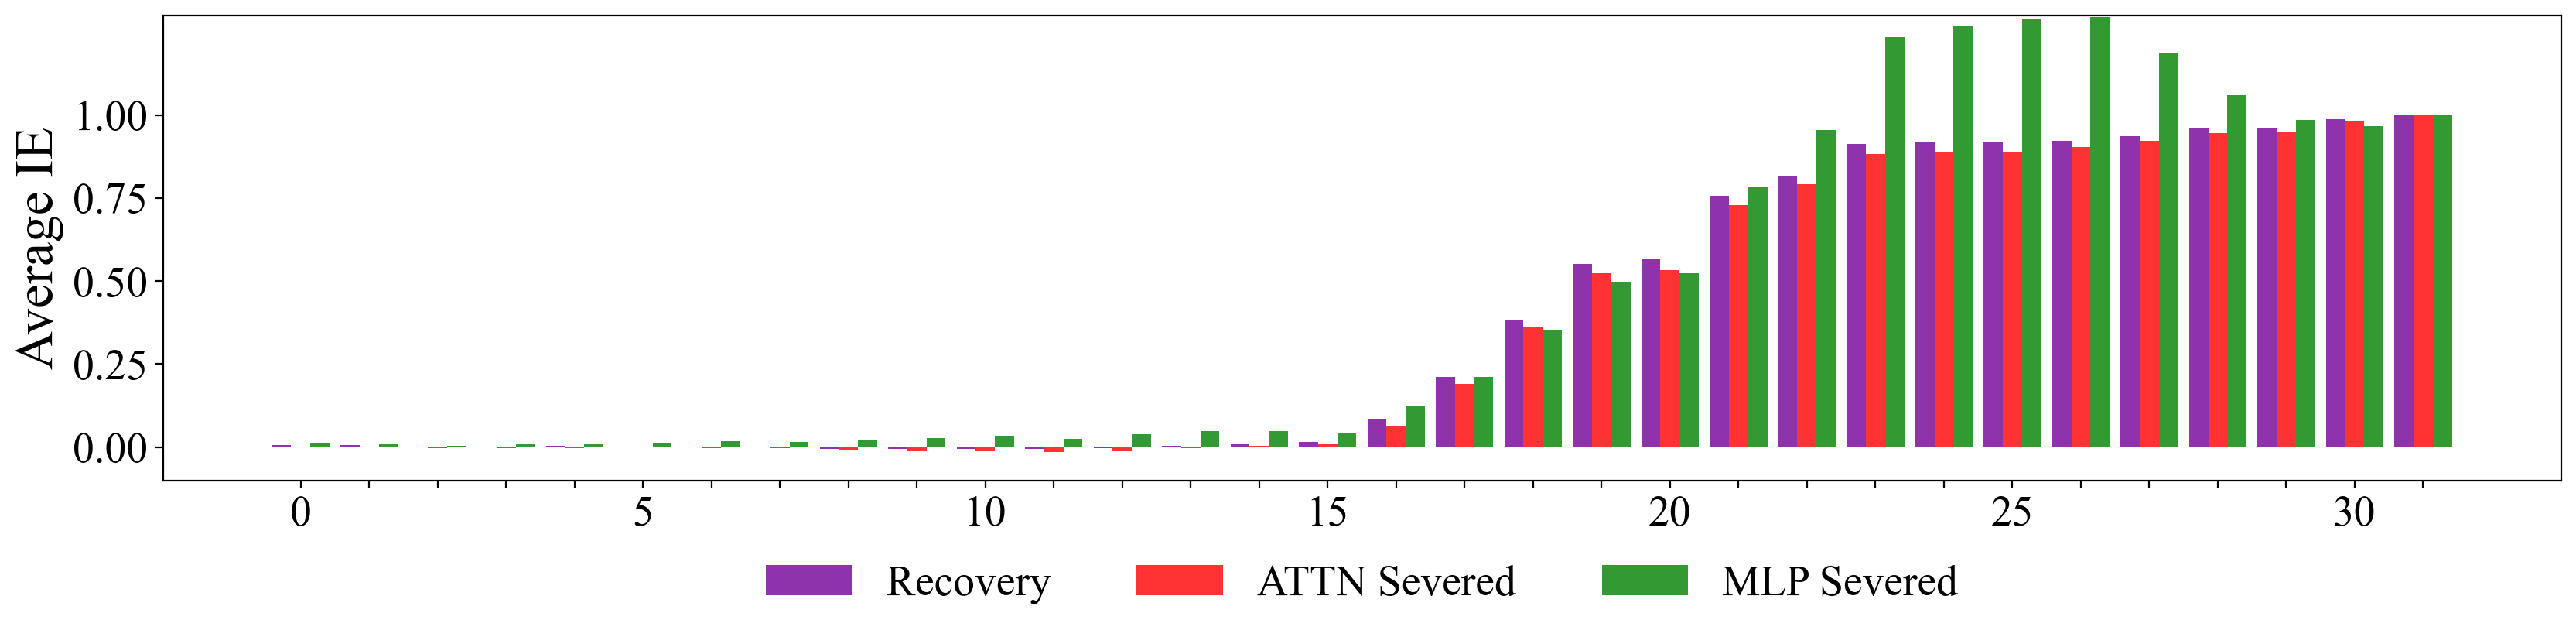

In [41]:
FIGURS_DIR = os.path.join("../../", "Figures")


patch_recovery_avg = torch.Tensor(patch_recovery_all).mean(dim=0).squeeze().numpy()
attn_severed_avg = torch.Tensor(attn_severed_all).mean(dim=0).squeeze().numpy()
mlp_severed_avg = torch.Tensor(mlp_severed_all).mean(dim=0).squeeze().numpy()

plot_patch_blocking_results(
    patch_recovery_avg,
    attn_severed_avg,
    mlp_severed_avg,
    savepdf=os.path.join(FIGURS_DIR, f"{MODEL}_{at_token}_path_blocking.pdf")
)